In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import matplotlib.colors as mcolors
import time
import collections
from networkx.drawing.nx_agraph import graphviz_layout
from networkx.algorithms.community import k_clique_communities
from community import community_louvain

/Users/siyudeng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Open amazon0302.txt and convert to .csv file
with open('amazon0302.txt', 'rt') as f:

    data = pd.read_csv(f, delim_whitespace=True, header=None)

data.to_csv('amazon.csv', index=False)

In [3]:
data = pd.read_csv('amazon.csv')
number_of_rows = len(data)

# Split file with first 0.5%
split_rows = int(0.005 * number_of_rows)
small_data = data.iloc[:split_rows]

small_data.to_csv('smallamazon.csv', index=False)

In [4]:
# Visualisation helper functions
def draw(G, pos, measures, measure_name):
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    edges = nx.draw_networkx_edges(G, pos)
    plt.title(measure_name, fontsize=30)
    #plt.colorbar(nodes)
    plt.axis('off')
    plt.show()  

In [6]:
#def dict_sort_by_value(dict_input):
    #return sorted(dict_input.items(), key=lambda x: x[1], reverse=True)

In [5]:
# read file
df = pd.read_csv("smallamazon.csv")
df

0     1
0        0     1
1        0     2
2        0     3
3        0     4
4        0     5
...    ...   ...
6169  1293  1534
6170  1293  1535
6171  1293  1606
6172  1294   699
6173  1294  1295

[6174 rows x 2 columns]

In [6]:
net = nx.from_pandas_edgelist(df, source='0', target='1', create_using=nx.DiGraph())
#un_G = nx.Graph()
#G = un_G.to_directed()
G = nx.Graph()

In [7]:
for idx, row in df.iterrows():
    G.add_edge(row[0], row[1])

# output nodes and edges
len(G.nodes), len(G.edges)

(2180, 4822)

In [8]:
# find 3-cliques
def find_cliques(G, k):
    def is_clique(s):
        for v in s:
            if not all(v in G[u] for u in s if u != v):
                return False
        return True
    
    nodes = list(G.nodes())
    cliques = set()  # Use a set to store unique cliques

    def _find_cliques(cur_clique, candidates):
        if len(cur_clique) >= k:
            cliques.add(frozenset(cur_clique))  # Add the clique to the set
        
        for candidate in candidates:
            if all(candidate in G[node] for node in cur_clique):
                _find_cliques(cur_clique + [candidate], [n for n in candidates if n in G[candidate]])

    for start_node in nodes:
        _find_cliques([start_node], [n for n in nodes if n in G[start_node]])

    filtered_cliques = [c for c in cliques if len(c) >= k]  # Convert set back to list

    return filtered_cliques

# Example usage
k = 3
# Assuming G is a networkx Graph created from your dataframe
G = nx.from_pandas_edgelist(df, source='0', target='1', create_using=nx.Graph())
cliques = find_cliques(G, k)

print("Cliques with size at least", k, ":")
print(cliques)


Cliques with size at least 3 :
[frozenset({1272, 673, 279}), frozenset({481, 1154, 342}), frozenset({377, 330, 721}), frozenset({706, 293, 358}), frozenset({432, 433, 435, 756}), frozenset({536, 465, 186, 585}), frozenset({690, 1147, 327}), frozenset({706, 290, 292, 293}), frozenset({250, 244, 494}), frozenset({697, 1290, 1291, 1293}), frozenset({1120, 274, 1122}), frozenset({105, 106, 134, 122}), frozenset({638, 852, 142}), frozenset({688, 690, 1147}), frozenset({17, 169, 31}), frozenset({20, 111, 78, 23}), frozenset({210, 154, 20}), frozenset({271, 38, 270}), frozenset({1466, 902, 1151}), frozenset({523, 524, 525}), frozenset({241, 250, 252, 494}), frozenset({34, 275, 52, 277}), frozenset({412, 547, 156}), frozenset({720, 721, 723, 718}), frozenset({329, 217, 327}), frozenset({748, 1004, 910}), frozenset({9, 30, 7}), frozenset({344, 528, 800, 526}), frozenset({205, 206, 207}), frozenset({210, 829, 446}), frozenset({128, 129, 130, 78, 113}), frozenset({585, 465, 534, 536, 827}), froze

In [9]:
# Implementing the community detection algorithms
def get_percolated_cliques(G, k):
    #cliques = list(frozenset(c) for c in nx.find_cliques(G) if len(c) >= k)
    cliques = find_cliques(G, k)
    print(cliques)
    matrix = np.zeros((len(cliques), len(cliques)))
    print(matrix)
    
    for i in range(len(cliques)):
        for j in range(len(cliques)):
            if i == j:
                n = len(cliques[i])
                if n >= k:
                    matrix[i][j] = 1
                else:
                    matrix[i][j] = 0
            else:
                n = len(cliques[i].intersection(cliques[j]))
                if n >= k-1:
                    matrix[i][j] = 1
                else:
                    matrix[i][j] = 0
    
    l = list(range(len(cliques)))
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if matrix[i][j] == 1 and i != j:
                l[j] = l[i]
    
    q = []
    for i in l:
        if i not in q:
            q.append(i)
    
    p = []
    for i in q:
        p.append(list(frozenset.union(*[cliques[j] for j in range(len(l)) if l[j] == i])))
    return p

In [10]:
# Calculate modularity Q
def cal_Q(partition, G):
    m = len(G.edges(None, False))
    a = []
    e = []
    for community in partition:
        t = 0.0
        for node in community:
            t += len([x for x in G.neighbors(node)])
        a.append(t/(2*m))
        
    for community in partition:
        t = 0.0
        for i in range(len(community)):
            for j in range(len(community)):
                if G.has_edge(community[i], community[j]):
                    t += 1.0
        e.append(t/(2*m))
        
    q = 0.0
    for ei, ai in zip(e, a):
        q += (ei - ai**2) 
    return q 


In [11]:
# Calculate the extended modularity EQ
def cal_EQ(cliques, G):
    m = len(G.edges(None, False))
    vertex_community = collections.defaultdict(lambda: set())
    for i, c in enumerate(cliques):
        for v in c:
            vertex_community[v].add(i)
    total = 0.0
    for c in cliques:
        for i in c:
            o_i = len(vertex_community[i])
            k_i = len(G[i])
            for j in c:
                t = 0.0
                o_j = len(vertex_community[j])
                k_j = len(G[j])
                if G.has_edge(i, j):
                    t += 1.0 / (o_i * o_j)
                t -= k_i * k_j / (2 * m * o_i * o_j)
                total += t
    return round(total / (2 * m), 4)


[frozenset({1272, 673, 279}), frozenset({481, 1154, 342}), frozenset({377, 330, 721}), frozenset({706, 293, 358}), frozenset({432, 433, 435, 756}), frozenset({536, 465, 186, 585}), frozenset({690, 1147, 327}), frozenset({706, 290, 292, 293}), frozenset({250, 244, 494}), frozenset({697, 1290, 1291, 1293}), frozenset({1120, 274, 1122}), frozenset({105, 106, 134, 122}), frozenset({638, 852, 142}), frozenset({688, 690, 1147}), frozenset({17, 169, 31}), frozenset({20, 111, 78, 23}), frozenset({210, 154, 20}), frozenset({271, 38, 270}), frozenset({1466, 902, 1151}), frozenset({523, 524, 525}), frozenset({241, 250, 252, 494}), frozenset({34, 275, 52, 277}), frozenset({412, 547, 156}), frozenset({720, 721, 723, 718}), frozenset({329, 217, 327}), frozenset({748, 1004, 910}), frozenset({9, 30, 7}), frozenset({344, 528, 800, 526}), frozenset({205, 206, 207}), frozenset({210, 829, 446}), frozenset({128, 129, 130, 78, 113}), frozenset({585, 465, 534, 536, 827}), frozenset({344, 528, 800}), frozense

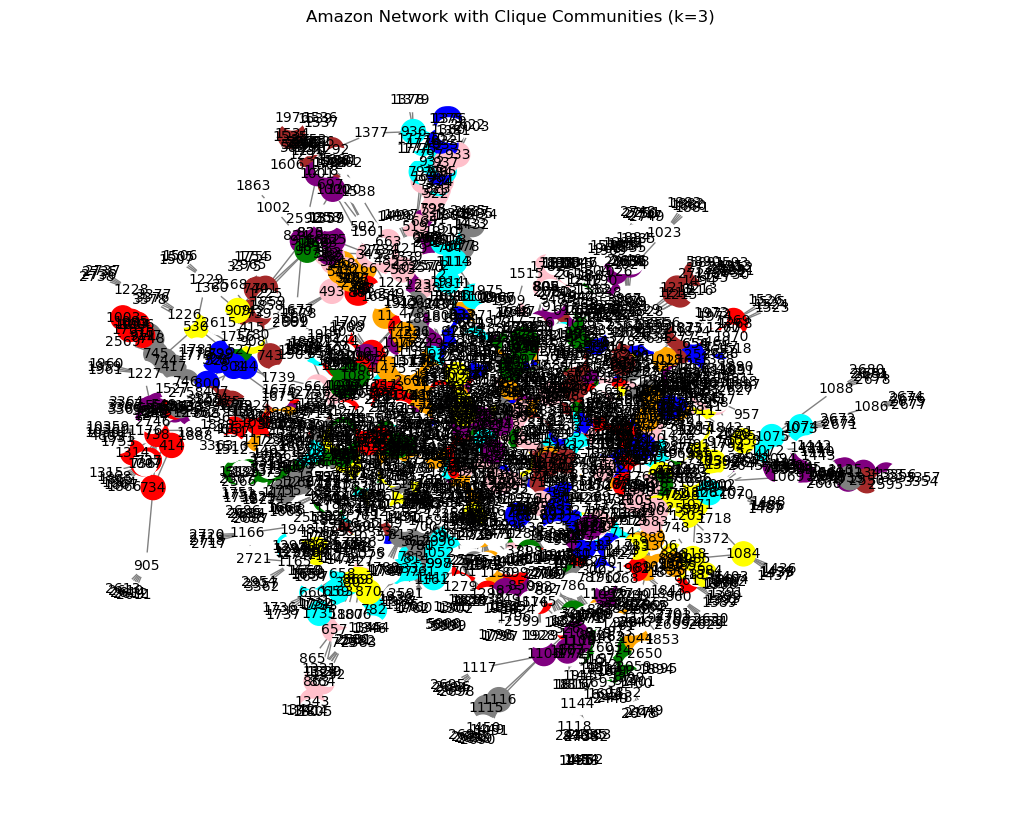

In [12]:
def add_group(p, G):
    num = 0
    nodegroup = {}
    for partition in p:
        for node in partition:
            nodegroup[node] = {'group': num}
        num += 1  
    nx.set_node_attributes(G, nodegroup) 

def setColor(G):
    color_map = []
    color = ['red', 'green', 'blue', 'yellow', 'purple', 'cyan', 'orange', 'pink', 'brown', 'gray']
    
    for node in G.nodes(data=True):
        if 'group' in node[1]:
            group_id = node[1]['group']
            color_map.append(color[group_id % len(color)])
        else:
            color_map.append('white')
    
    return color_map

G = nx.from_pandas_edgelist(df, source='0', target='1', create_using=nx.Graph())

# Apply percolated cliques method
k = 3
p = get_percolated_cliques(G, k)

# Calculate modularity Q
print("Modularity Q:", cal_Q(p, G))

#Calculate Extended Modularity EQ
eq_value = cal_EQ(cliques, G)
print("Extended Modularity EQ Value:", eq_value)

# Add group attributes to nodes
add_group(p, G)

# Draw the graph with labeled nodes and colored communities
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
node_color = setColor(G)
nx.draw(G, pos, with_labels=True, node_color=node_color, node_size=300, cmap=plt.cm.tab10, edge_color='gray', font_size=10)
plt.title('Amazon Network with Clique Communities (k=3)')
plt.show()


Modularity Q: 0.871133032773024
Extended Modularity EQ Value: 0.5277


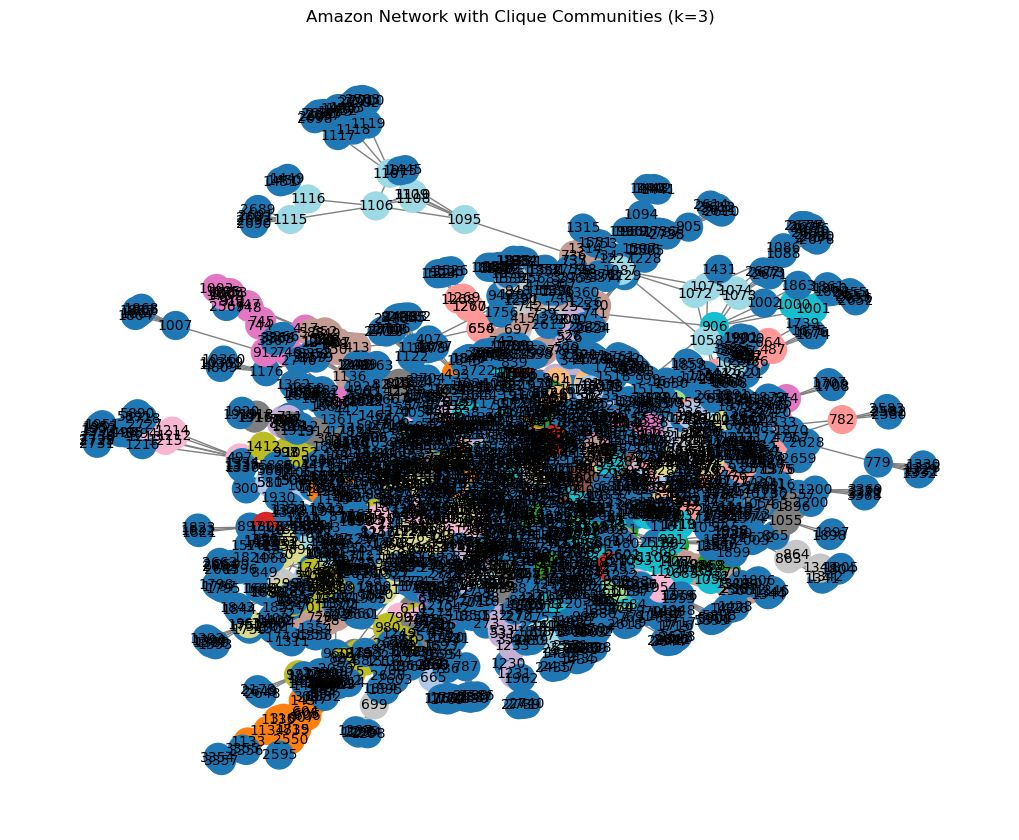

In [16]:
# Implementing the community detection algorithms using the NetworkX library - clique percolation method

# Find k-clique communities
clique_communities = list(k_clique_communities(G, 3))

# Create a mapping of node to community index
node_community_map = {node: idx for idx, comm in enumerate(clique_communities) for node in comm}

# Create a list of colors for nodes based on their community
node_colors = [node_community_map.get(node, -1) for node in G.nodes()]  # Use -1 for nodes not in any community

partition = community_louvain.best_partition(G)
modularity_q = community_louvain.modularity(partition, G)
print(f"Modularity Q: {modularity_q}")

#Calculate Extended Modularity EQ
eq_value = cal_EQ(clique_communities, G)
print("Extended Modularity EQ Value:", eq_value)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.tab20, node_size=400, edge_color='gray', font_size=10)
plt.title('Amazon Network with Clique Communities (k=3)')
plt.show()

In [48]:
# Print the node with highest degree and average degree of the network.
max_degree_node = max(G.degree, key=lambda x: x[1])
print("Node with highest degree:", max_degree_node)

average_degree = np.mean([d for n, d in G.degree()])
print("Average degree of the network:", average_degree)

Node with highest degree: (8, 46)
Average degree of the network: 4.423853211009174


In [49]:
# print the highest node degree and the lowest node degree
degrees = dict(G.degree())
max_degree_node = max(degrees, key=degrees.get)
min_degree_node = min(degrees, key=degrees.get)

print(f"Highest node degree: Node {max_degree_node}, Degree {degrees[max_degree_node]}")
print(f"Lowest node degree: Node {min_degree_node}, Degree {degrees[min_degree_node]}")

Highest node degree: Node 8, Degree 46
Lowest node degree: Node 287, Degree 1


In [50]:
# Calculating Diameter

scc_diameter = []
sccs = list(nx.connected_components(G))
for scc in sccs:
    if (len(scc) == 1):
      continue
    scc_subgraph = G.subgraph(scc)
    scc_diameter.append(nx.diameter(scc_subgraph))

graph_diameter = max(scc_diameter)
print(f"Diameter={graph_diameter}")


Diameter=19


Clustering coefficient global average: 0.2617453591974786
1.0


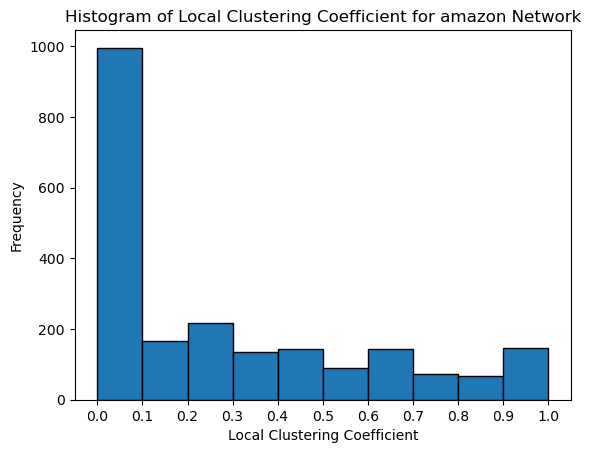

In [53]:
#Histogram of Local Clustering Coefficient of our network.

cc_global_avg = nx.average_clustering(G)
print("Clustering coefficient global average:", cc_global_avg)


local_cc = nx.clustering(G)
print(max(local_cc.values()))
plt.hist(list(local_cc.values()), bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                                          0.7, 0.8, 0.9, 1.0], edgecolor='black')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Local Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Histogram of Local Clustering Coefficient for amazon Network")
plt.show()
     

In [55]:
pos = nx.spring_layout(G, seed=123)

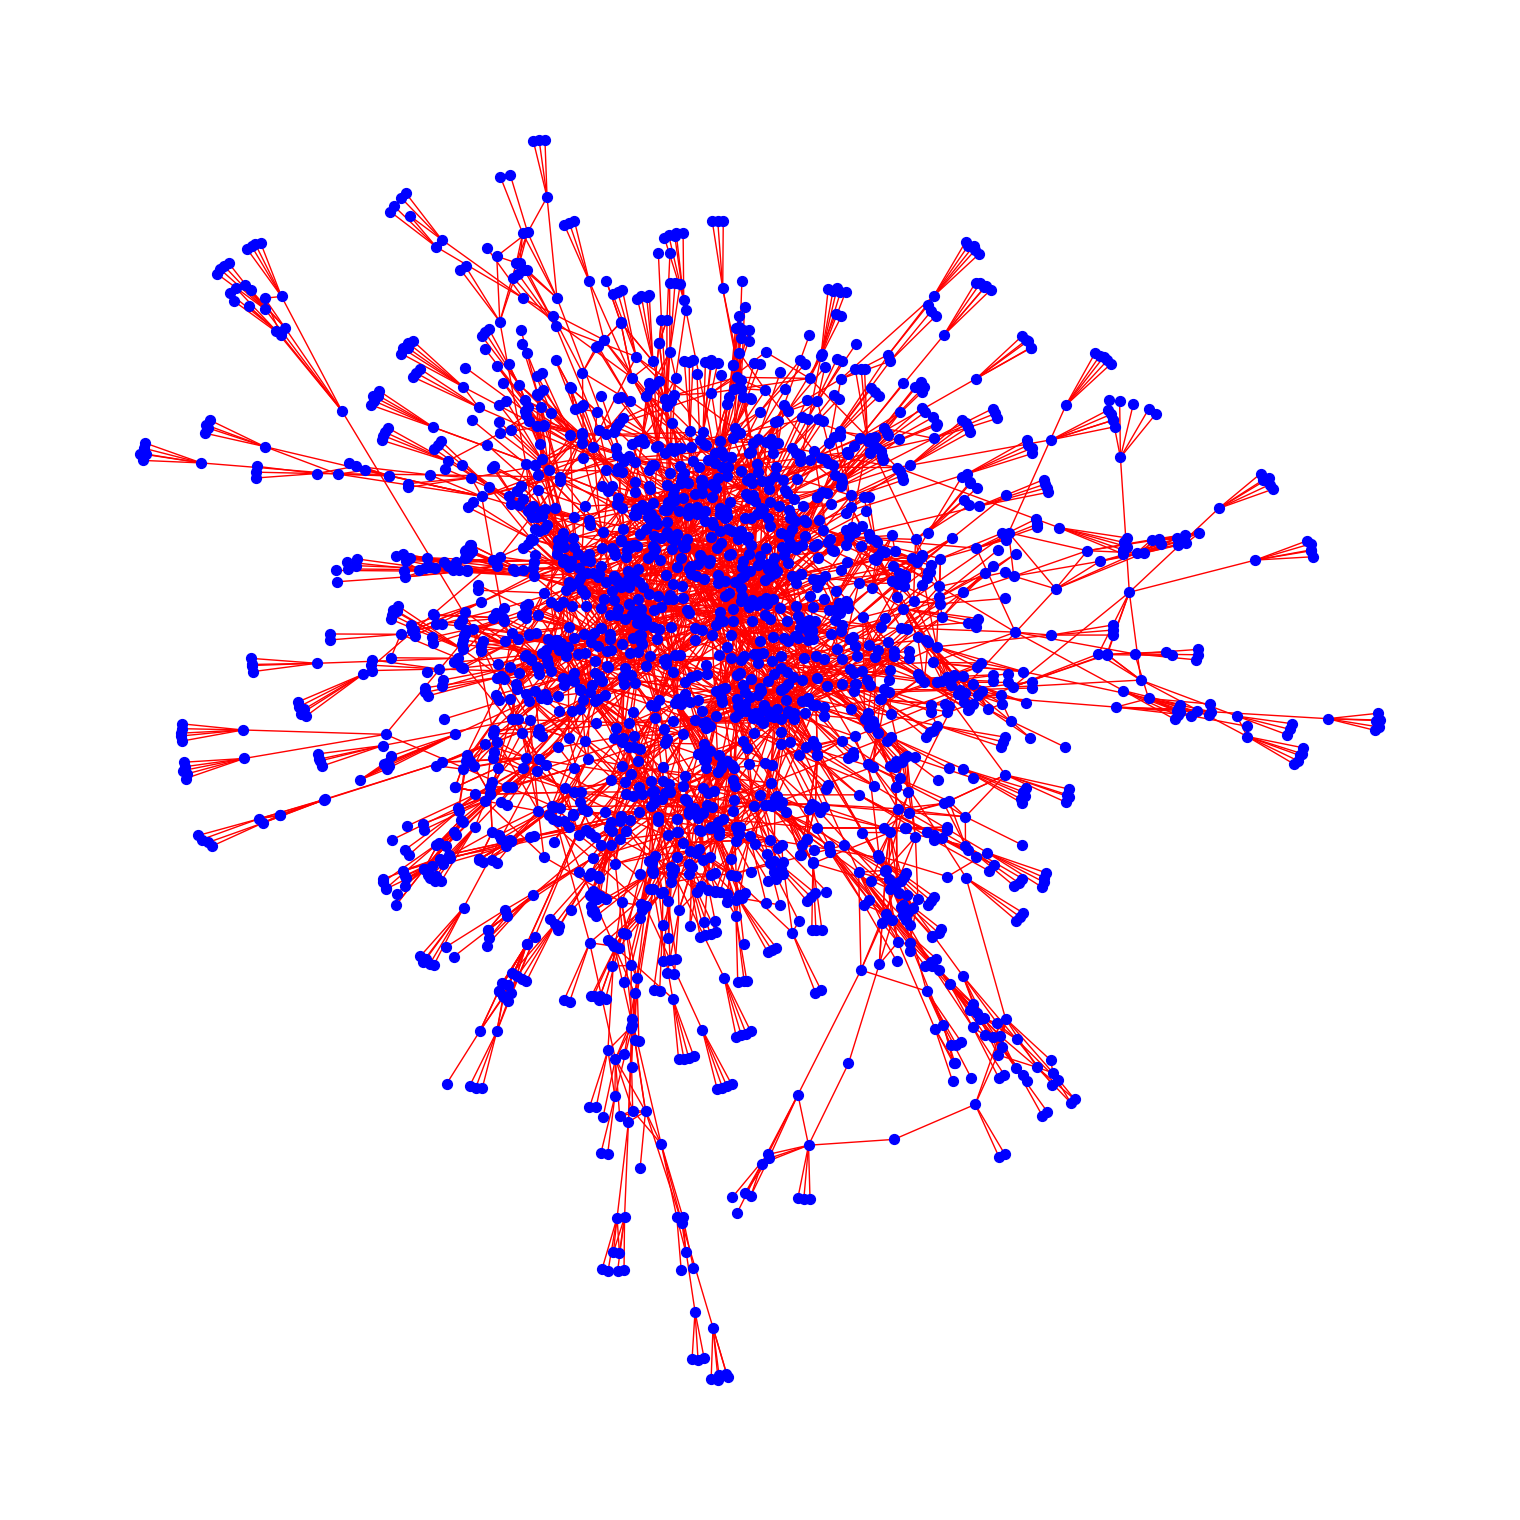

In [56]:
plt.figure(figsize=(15, 15))
nx.draw(G, pos=pos, node_size=50, node_color='blue', edge_color='red', with_labels=False)

In [57]:
# How many people buy similar things in the interval between node 1 and node 201
nx.has_path(G, 1, 201)

True

In [58]:
nx.shortest_path(G, 1, 201)

[1, 5, 8, 23, 201]

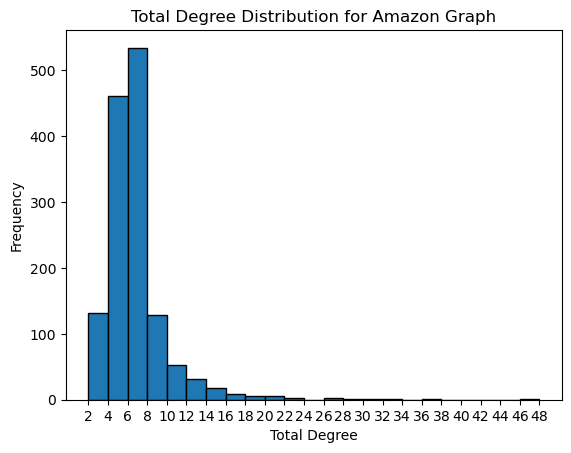

In [60]:
# Plot a histogram of the Total-Degree distribution of our network

degrees = [deg for node, deg in G.degree()]
plt.hist(degrees, bins=[x*2 for x in range(1,25)], edgecolor='black')
plt.xticks([x*2 for x in range(1,25)])
plt.xlabel('Total Degree')
plt.ylabel('Frequency')
plt.title('Total Degree Distribution for Amazon Graph')
plt.show()
     

In [61]:
# calculate the number of total cliques
# max cliques =6 , have max 6 products always buy together

total_cliques = list(nx.find_cliques(G))
num_total_cliques = len(total_cliques)
print('The number of total cliques is', num_total_cliques)

start_time = time.time()
largest_cliques = nx.find_cliques(G)
max_clique_size = max(len(clique) for clique in largest_cliques)
largest_cliques = [clique for clique in nx.find_cliques(G) if len(clique) == max_clique_size]
calculation_time = time.time() - start_time

maximal_6_cliques = [clique for clique in total_cliques if len(clique) == 6]
num_maximal_6_cliques = len(maximal_6_cliques)

num_total_cliques, num_maximal_6_cliques, max_clique_size, calculation_time

print('The size of the largest clique is', max_clique_size)
print('The number of maximal 6-cliques is', num_maximal_6_cliques)
print('The calculation time is', calculation_time)

The number of total cliques is 2536
The size of the largest clique is 7
The number of maximal 6-cliques is 23
The calculation time is 0.028460979461669922


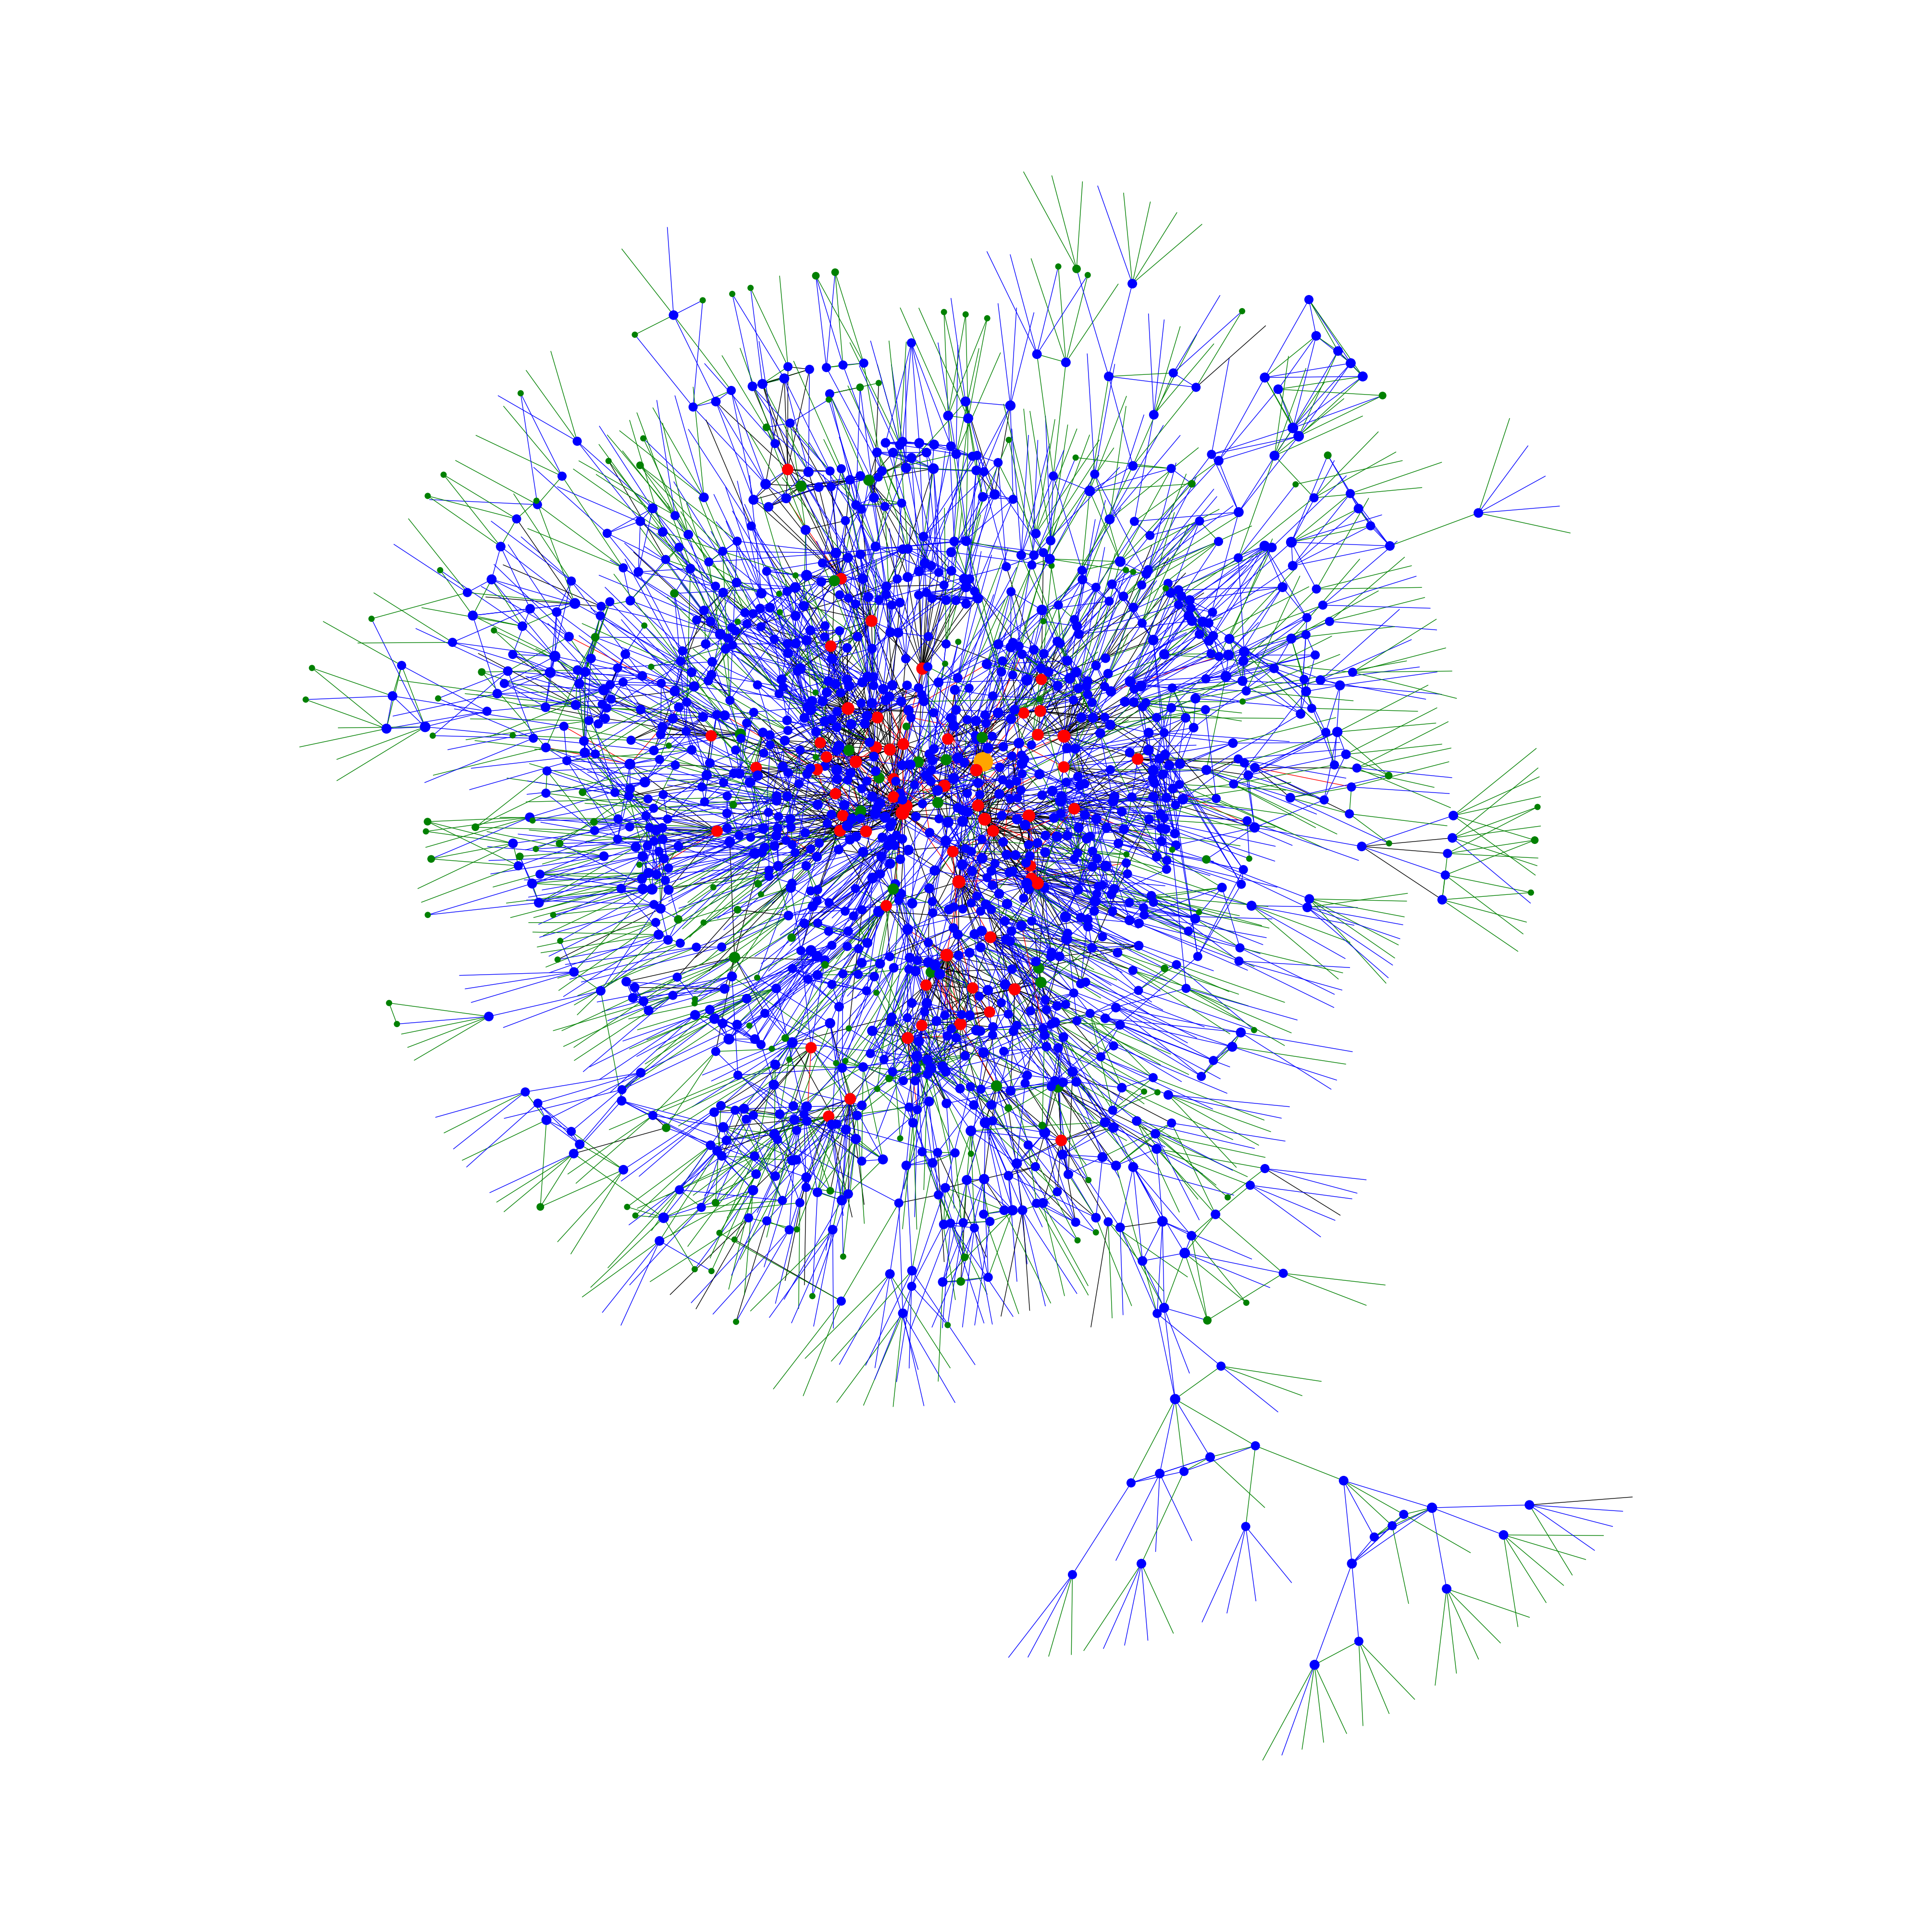

In [62]:
# Visualising Network

degrees = dict(G.degree())

# set node size proportional to degree
node_size = [100*np.log(degrees[node]) for node in G.nodes()]
node_size[0]= 800;

#Set node color to red if deg > 12, blue if deg > 4 and deg < 12 and green if deg < 4
node_color = []
for node in G.nodes():
    if degrees[node] > 12:
        node_color.append('red')
    elif degrees[node] > 4 and degrees[node] < 12:
        node_color.append('blue')
    else:
        node_color.append('green')
node_color[0]='orange'
edge_color = []
for edge in G.edges():
    if degrees[edge[0]] > 12 and degrees[edge[1]] > 12:
        edge_color.append('red')
    elif degrees[edge[0]] > 4 and degrees[edge[0]] < 12 and degrees[edge[1]] > 4 and degrees[edge[1]] < 12:
        edge_color.append('blue')
    elif degrees[edge[0]] < 4 or degrees[edge[1]] < 4:
        edge_color.append('green')
    elif degrees[edge[0]] != degrees[edge[1]]:
        edge_color.append('black')

fig = plt.figure(figsize=(40, 40))
nx.draw(G, node_size=node_size,node_color=node_color, edge_color = edge_color,pos=nx.kamada_kawai_layout(G))
plt.axis('equal')
plt.show()

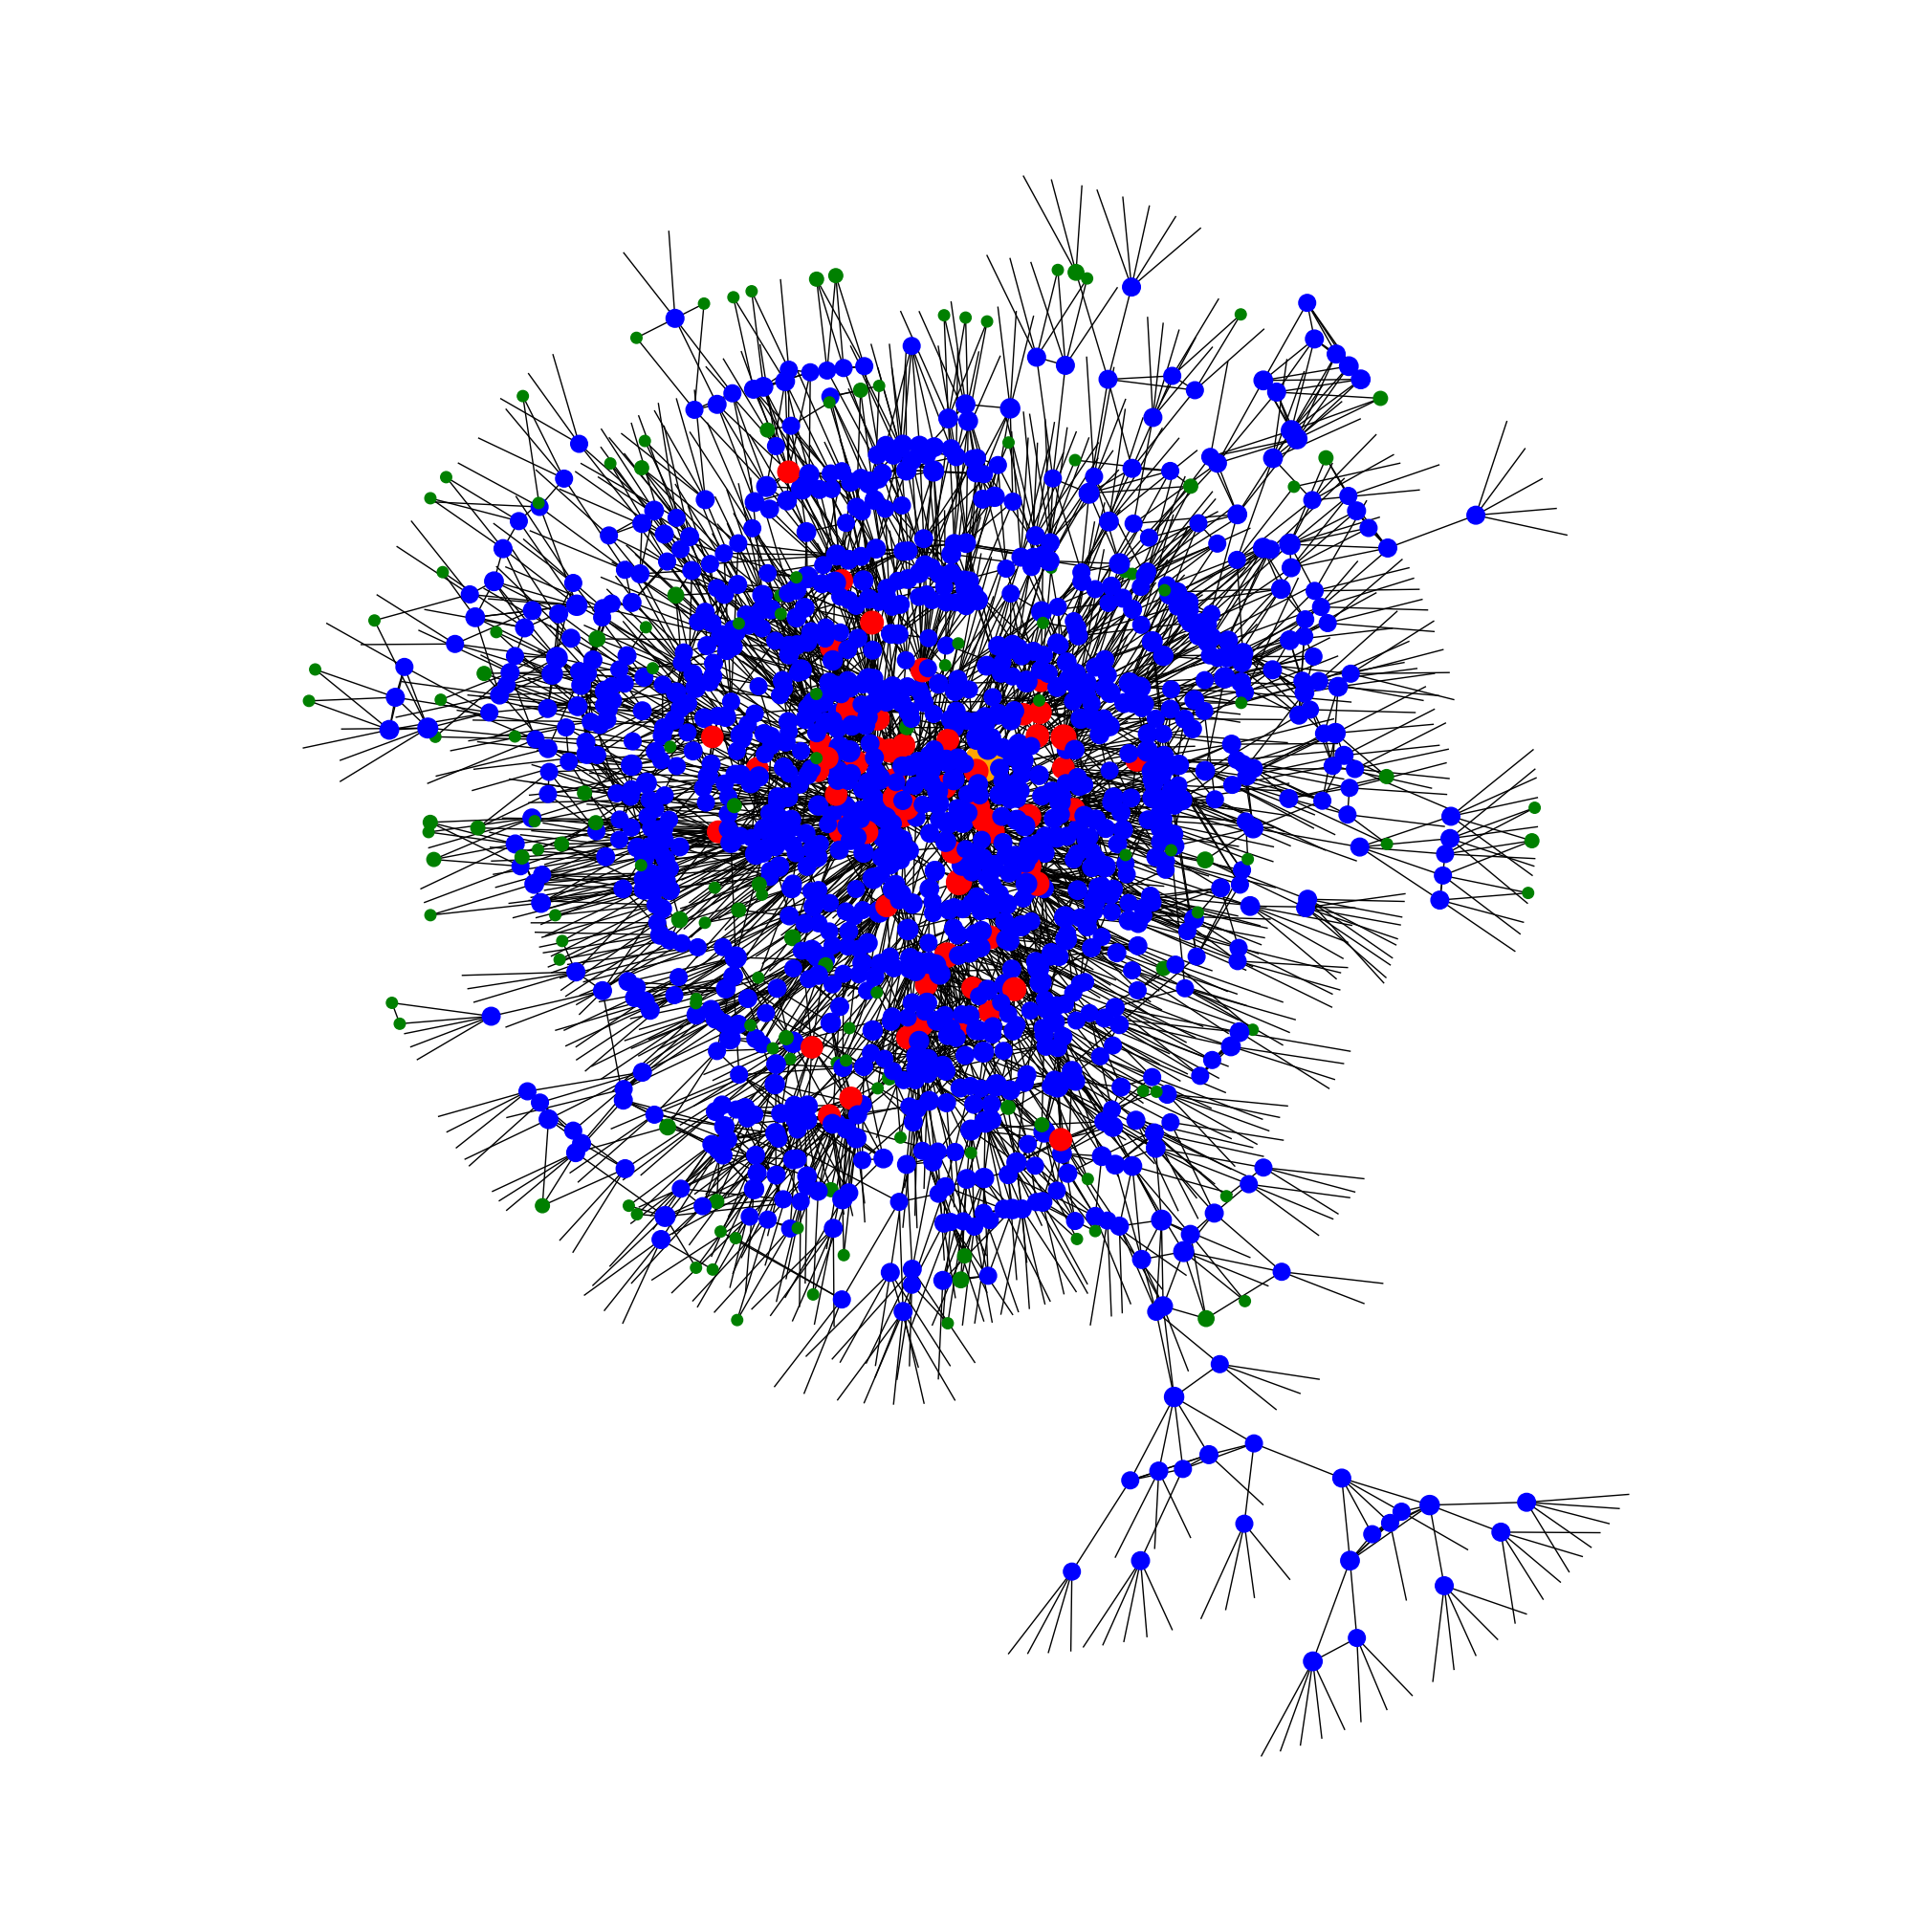

In [63]:
components = nx.connected_components(G)
largest_cc = max(components, key=len)
subgraph = G.subgraph(largest_cc)

degrees = dict(subgraph.degree())

# set node size proportional to degree
node_size = [100 * np.log(degrees[node]) for node in subgraph.nodes()]
node_size[0] = 800

# Set node color based on degree
node_color = ['red' if degrees[node] > 12 else 'blue' if degrees[node] > 4 else 'green' for node in subgraph.nodes()]
node_color[0] = 'orange'

fig = plt.figure(figsize=(20, 20))
nx.draw(subgraph, node_size=node_size, node_color=node_color, pos=nx.kamada_kawai_layout(subgraph))
plt.axis('equal')
plt.show()